by Maciej Marcinkiewicz (300171) and Katarzyna Bielecka (300165)

In [9]:
import pandas as pd
import numpy as np

from sklearn.model_selection import  KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

import seaborn as sns
from matplotlib import pyplot as plt

import torch
from torch import nn 
from torch import optim

# Data preprocessing

## Data loading and preview

In [10]:
df = pd.read_csv("Iris.csv")
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


 We start from removing the ID column as it is not providing any information which could help with species prediction - it is helpful only
 from the organizational point of view for the data owner/maintainer.

In [11]:
df = df.drop(["Id"], axis=1)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


## Categorical data encoding and selection of data to be predicted

We want to predict species of Iris based on parameters. Below we check how many species we have - they will define our classes in the classification problem.

In [13]:
labels = df.Species.unique()

As stated above, we will predict the species. Thus we assign it to Y and encode it with values 0-2. To X we assign the rest of data. 

In [14]:
X = df.drop(["Species"], axis=1).values
Y = df.Species.map(lambda x: np.where(labels == x)[0][0]).values

In order to use data in pytorch functions we need to convert it into tensor form, as below. Also a type change was needed as methods accepted float type, and initially the type was double. 

In [15]:
X_tensor = torch.from_numpy(X).type(torch.FloatTensor)
Y_tensor = torch.from_numpy(Y).type(torch.LongTensor)

# Model and functions definition

## Model

Below we defined a sequential neural network model with 4 layers total: the input layer, two hidden layers and the output layer. We chose arbitrary numbers for the number of neurons. As the activation function, we chose a rather popular one - the ReLu (Rectified Linear Unit) function. What is worth mentioning we also tried using the sigmoid function instead, just to compare but the results were significantly worse - that is why we ended up choosing ReLu.

In [16]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(input_dim, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, output_dim)
        )

    def forward(self, x):
        return self.linear_stack(x)


class NeuralNetwork5(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(input_dim, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, 100),
            nn.ReLU(),
            nn.Linear(100, output_dim)
        )

    def forward(self, x):
        return self.linear_stack(x)

## Functions for the training and evaluation process

### Training function

In [17]:
def train(model, X_train, y_train, loss_func, num_of_epochs, optimizer):
    train_loss, train_accuracy = [], []

    for epoch in range(num_of_epochs):
        optimizer.zero_grad()

        output = model(X_train)
        y_pred = output.argmax(1)

        loss = loss_func(output, y_train)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

        acc = accuracy_score(y_pred=y_pred, y_true=y_train)
        train_accuracy.append(acc)

    return train_loss, train_accuracy

### Metrics and plots functions

In [18]:
def metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")

    print(f"Accuracy: {acc}\nMacro precision: {prec}\nMacro recall: {recall}")

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="")
    plt.title("Confusion matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

In [19]:
def linear_plot(epochs, y, title, ylabel):
    x = list(range(1, epochs + 1))
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel(ylabel)
    plt.plot(x, y)
    plt.show()

### Model evalation function

Below, a function for kfold evaluation is implemented. We used a built-in Stochastic Gradient Descent optimization ffunction for training. Moreover, parameters for the Neural Networks are fixed as they will not change - we have 4 dimensions for input - 4 parameteters describing the properties of Iris species, and 3 outputs - for probabibilities of each species. 

In [20]:
def kfold_evalution(params_dict):
    kf = KFold(n_splits = params_dict["cv"], shuffle=True)

    for fold, (train_idx, test_idx) in enumerate(kf.split(params_dict["X"])):
        print(f"Fold {fold + 1}")    
        X_train, X_test = params_dict["X"][train_idx], params_dict["X"][test_idx]
        y_train, y_test = params_dict["Y"][train_idx], params_dict["Y"][test_idx]

        model = params_dict["model"](input_dim=4, output_dim=3).to(device)
        optimizer = optim.SGD(model.parameters(), lr=0.01)

        train_loss, train_accuracy = train(model, X_train, y_train, params_dict["loss_func"], params_dict["epochs"], optimizer)

        linear_plot(params_dict["epochs"], train_loss, "Loss function values", "loss function")
        linear_plot(params_dict["epochs"], train_accuracy, "Training accuracies", "accuracy")

        with torch.no_grad():
            y_pred_test = model(X_test).argmax(1)

        metrics(y_test, y_pred_test)

# Evaluation

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 3 layers model

## Cross entropy loss function

First version of the model we test is one defined with cross entropy loss function. It is a commonly used function for multi-class classification problems. 

In [22]:
params = {
    "loss_func": nn.CrossEntropyLoss(),
    "X": X_tensor,
    "Y": Y_tensor,
    "cv": 5,
    "epochs": 200,
    "model": NeuralNetwork
}

Fold 1


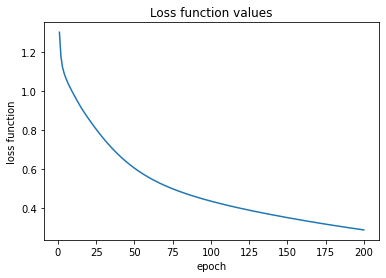

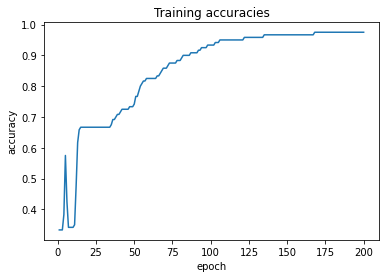

Accuracy: 0.9666666666666667
Macro precision: 0.9666666666666667
Macro recall: 0.9666666666666667


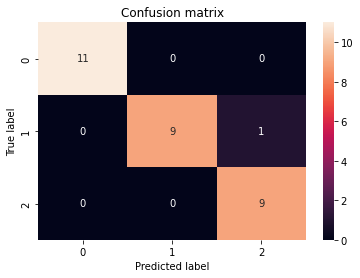

Fold 2


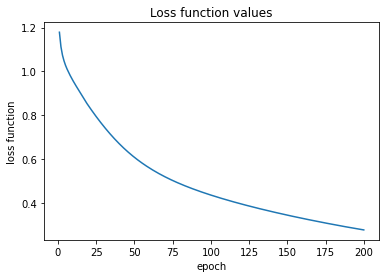

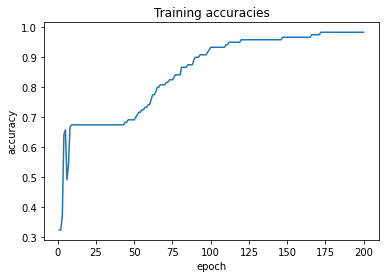

Accuracy: 0.9333333333333333
Macro precision: 0.9444444444444445
Macro recall: 0.9393939393939394


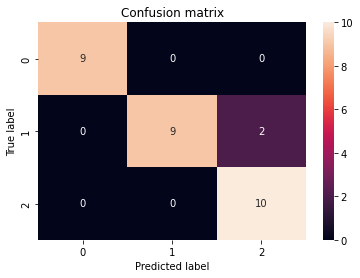

Fold 3


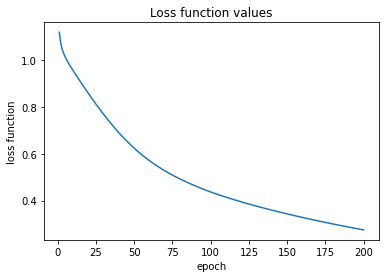

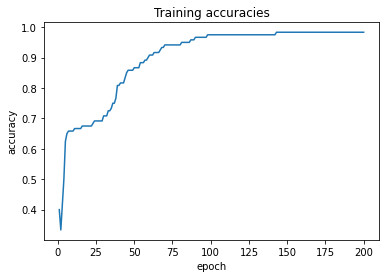

Accuracy: 0.9666666666666667
Macro precision: 0.9743589743589745
Macro recall: 0.9629629629629629


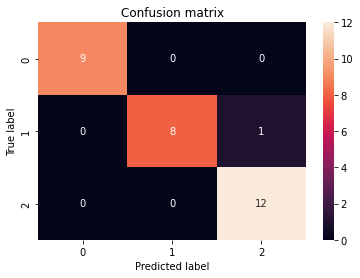

Fold 4


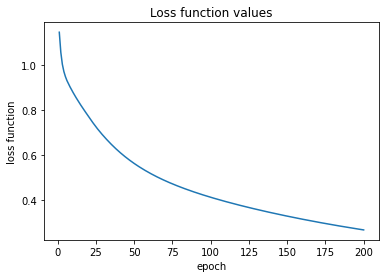

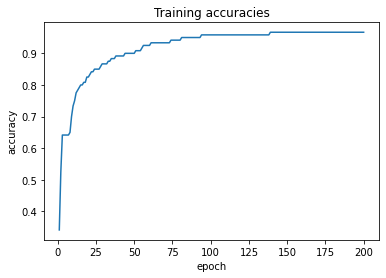

Accuracy: 1.0
Macro precision: 1.0
Macro recall: 1.0


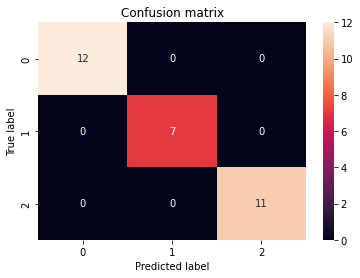

Fold 5


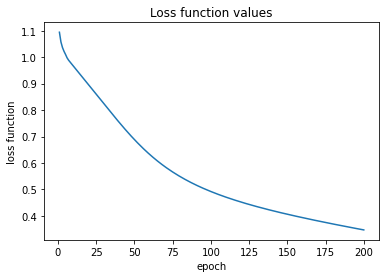

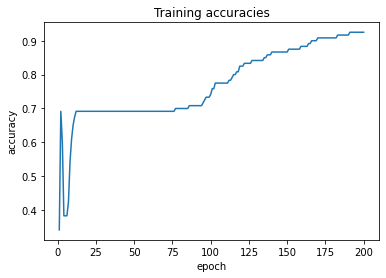

Accuracy: 0.9666666666666667
Macro precision: 0.9629629629629629
Macro recall: 0.9743589743589745


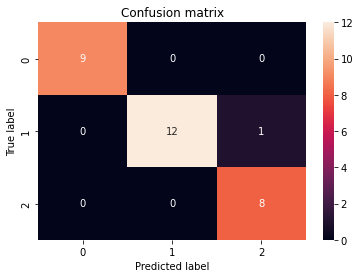

In [23]:
kfold_evalution(params)

As we can see accuracy obtained by the model is very high across all folds - ranging from 1 at most to 0.9 at worst. All the other metrics are very good as well. It is possible that due to a rather small dataset we were able to achieve such good results with just one (hidden) layer. 

## Margin-based loss function

In [24]:
params = {
    "loss_func": nn.MultiMarginLoss(),
    "X": X_tensor,
    "Y": Y_tensor,
    "cv": 5,
    "epochs": 200,
    "model": NeuralNetwork
}

Fold 1


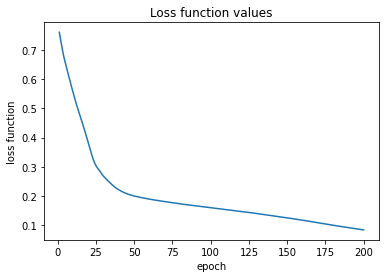

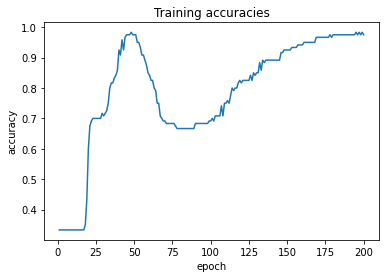

Accuracy: 0.9666666666666667
Macro precision: 0.9777777777777779
Macro recall: 0.9666666666666667


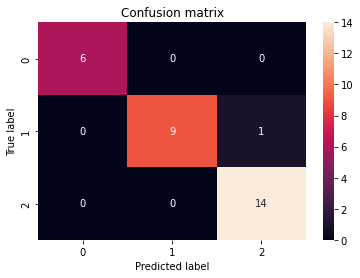

Fold 2


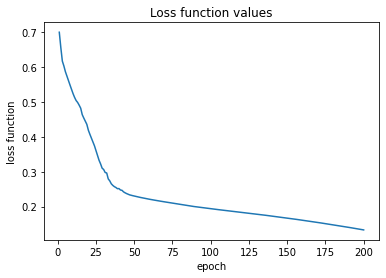

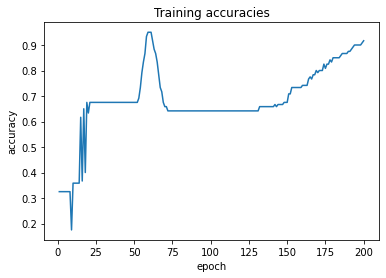

Accuracy: 0.9666666666666667
Macro precision: 0.9722222222222222
Macro recall: 0.9523809523809524


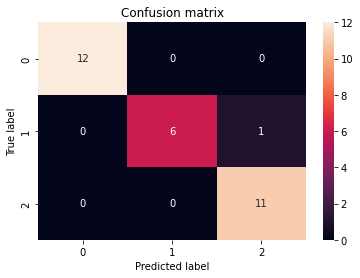

Fold 3


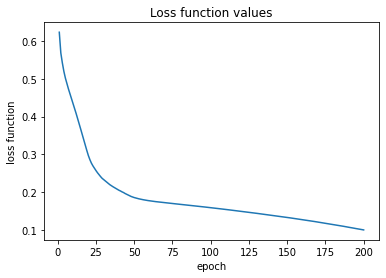

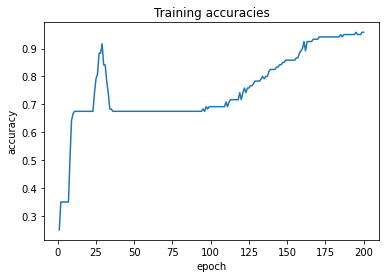

Accuracy: 1.0
Macro precision: 1.0
Macro recall: 1.0


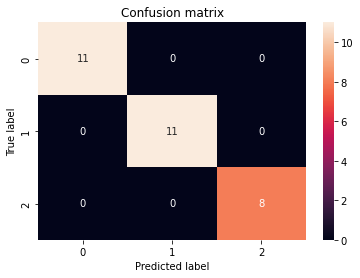

Fold 4


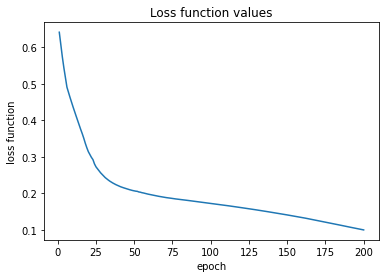

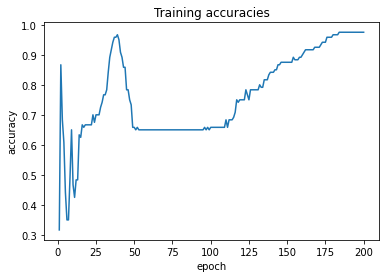

Accuracy: 0.9333333333333333
Macro precision: 0.9444444444444445
Macro recall: 0.9166666666666666


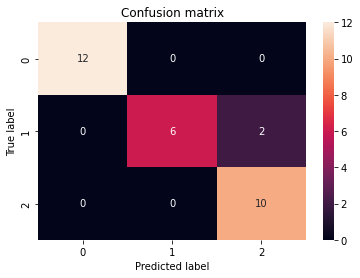

Fold 5


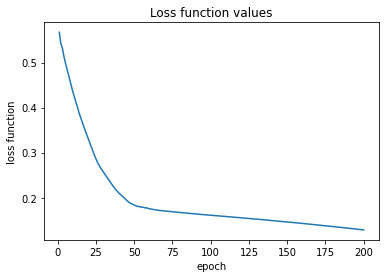

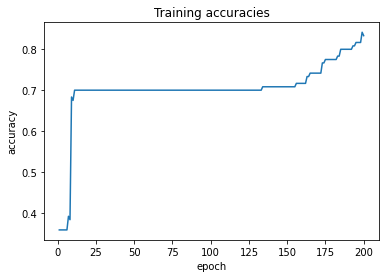

Accuracy: 0.8
Macro precision: 0.8461538461538461
Macro recall: 0.8571428571428571


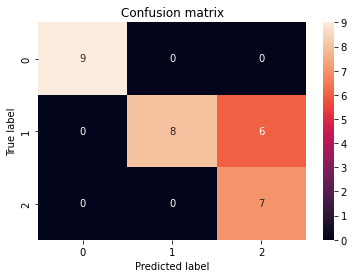

In [25]:
kfold_evalution(params)

As one can notice application of margin-based loss yielded similiarly good results as the previosly used loss function. With accuracy ranging from 0.93 to 1. Though, it is worth noting that it took more training time for this method to arrive at such good accuracy. We may notice that the cross entropy loss attempt reached good accuracy within less number of epochs. Thus, we may conclude that it is faster, at least in our case. 

# 5 layers model

## Cross entropy loss function

In [26]:
params = {
    "loss_func": nn.CrossEntropyLoss(),
    "X": X_tensor,
    "Y": Y_tensor,
    "cv": 5,
    "epochs": 200,
    "model": NeuralNetwork5
}

Fold 1


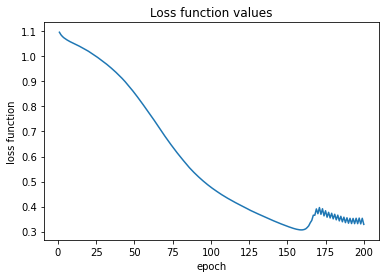

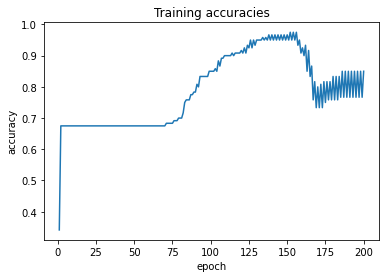

Accuracy: 0.8333333333333334
Macro precision: 0.8888888888888888
Macro recall: 0.8484848484848485


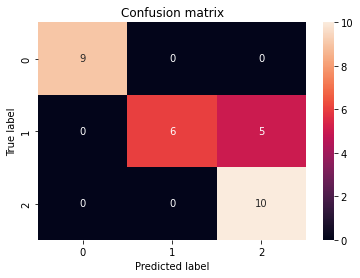

Fold 2


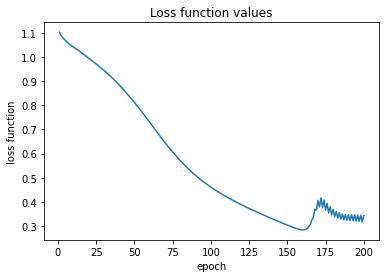

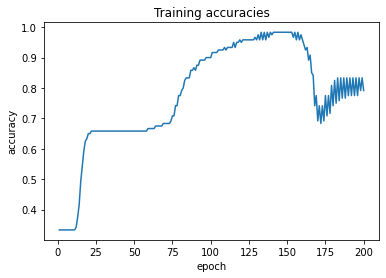

Accuracy: 0.8333333333333334
Macro precision: 0.8809523809523809
Macro recall: 0.8333333333333334


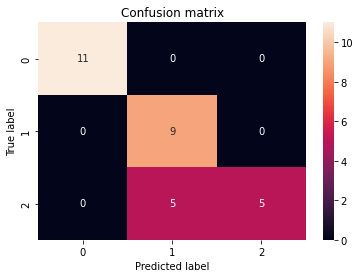

Fold 3


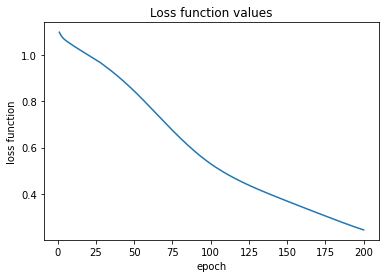

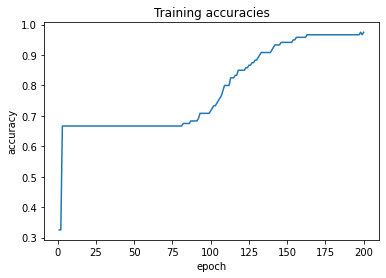

Accuracy: 0.9666666666666667
Macro precision: 0.9666666666666667
Macro recall: 0.9666666666666667


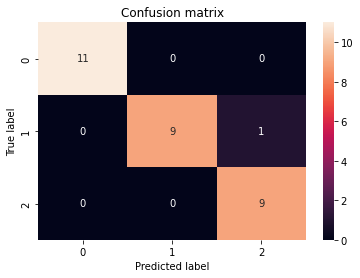

Fold 4


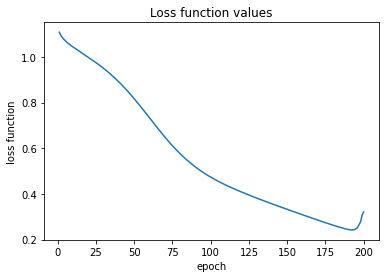

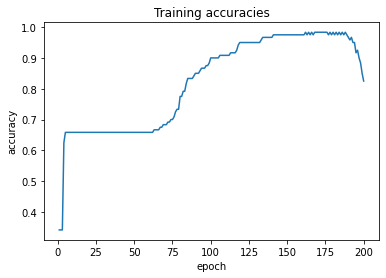

Accuracy: 0.7333333333333333
Macro precision: 0.8666666666666667
Macro recall: 0.7037037037037037


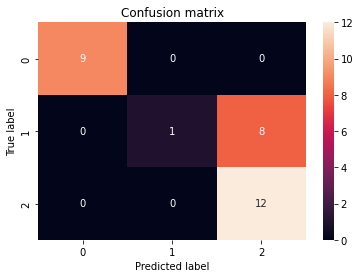

Fold 5


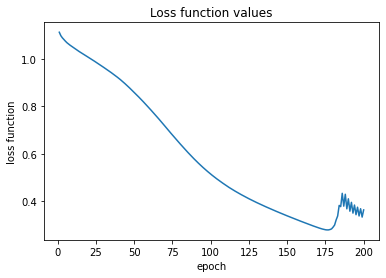

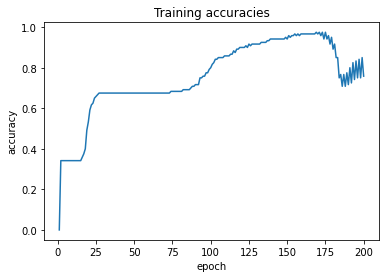

Accuracy: 0.8
Macro precision: 0.8823529411764706
Macro recall: 0.7777777777777778


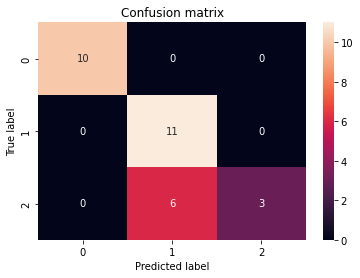

In [27]:
kfold_evalution(params)

lcmsdlcokasx here comment

## Margin-based loss function

In [32]:
params = {
    "loss_func": nn.MultiMarginLoss(),
    "X": X_tensor,
    "Y": Y_tensor,
    "cv": 5,
    "epochs": 200,
    "model": NeuralNetwork5
}

Fold 1


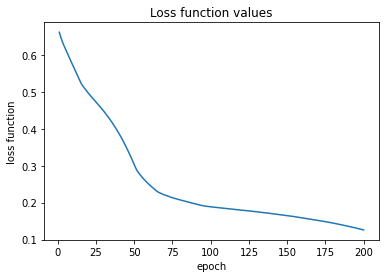

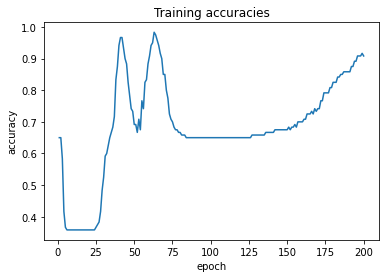

Accuracy: 0.9
Macro precision: 0.9
Macro recall: 0.875


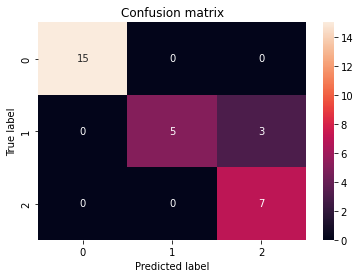

Fold 2


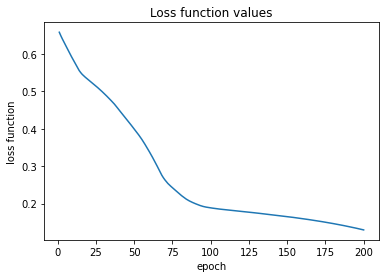

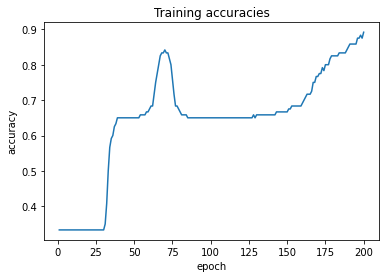

Accuracy: 0.9666666666666667
Macro precision: 0.9696969696969697
Macro recall: 0.9583333333333334


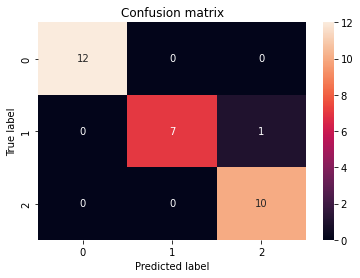

Fold 3


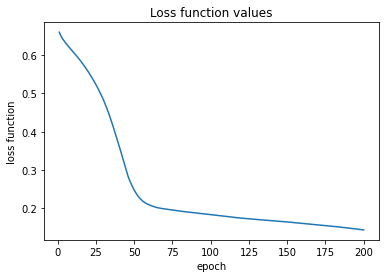

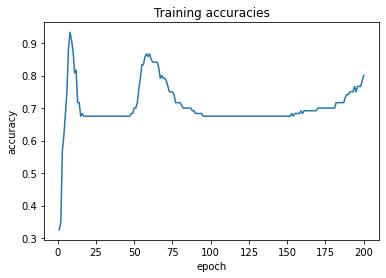

Accuracy: 0.9666666666666667
Macro precision: 0.9761904761904763
Macro recall: 0.9696969696969697


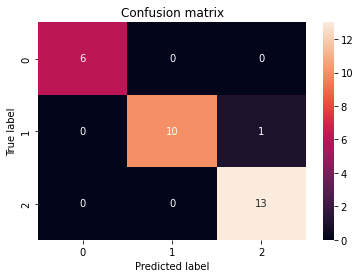

Fold 4


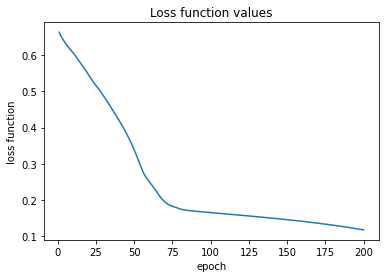

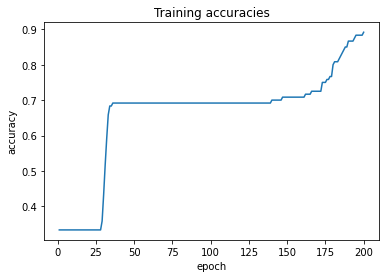

Accuracy: 0.7
Macro precision: 0.8421052631578947
Macro recall: 0.7692307692307692


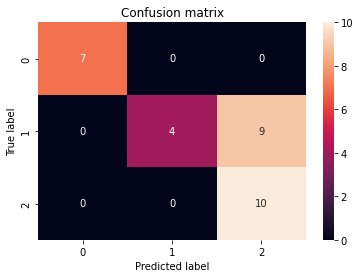

Fold 5


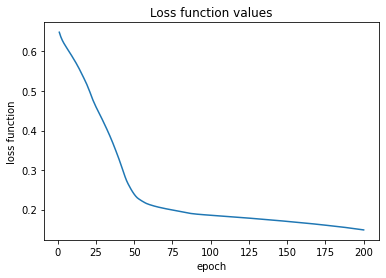

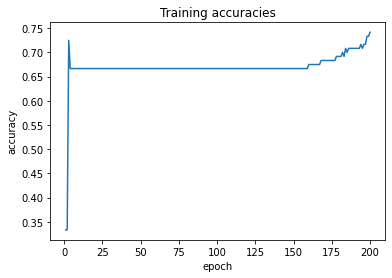

Accuracy: 0.7
Macro precision: 0.8421052631578947
Macro recall: 0.7000000000000001


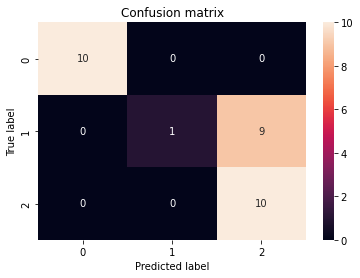

In [33]:
kfold_evalution(params)

Using model with 3 hidden layers (total 5) worsened the results independetly of the used loss function. However, in this case, contrary to less layers case margin loss yielded better results. 
We then may conclude that in our case increasing number of layers (and also neurons) negatively affects accuracy.